In [1]:
import sys
sys.path.extend(["../", "../src"])

In [2]:
from tqdm import tqdm
import numpy as np
from scipy.stats import poisson

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import pnr_povm, diag_povm_fidelity, diag_mse_norm
from src.utils import check_diag_povm, find_lambda_max
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed)
np.random.seed(seed);

In [3]:
M = 200
device = 'cpu'
N = 25
D = 2000
errs = np.logspace(-2, 0, 15) # range is 10^-2 to 10^0 (1) (variances)
eta = 1.
lam_smoothing = 0e-5
gd_trials = 20
avg_fids_gd_sample = []
avg_mses_gd_sample = []
avg_fids_mosek = []
avg_mses_mosek = []
iters_mosek = []
batch_size = 25
hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=batch_size)

In [4]:
print(errs)

[0.01       0.01389495 0.01930698 0.02682696 0.03727594 0.05179475
 0.07196857 0.1        0.13894955 0.19306977 0.26826958 0.37275937
 0.51794747 0.71968567 1.        ]


In [5]:
for err in tqdm(errs, desc="Performing noise experiments"):
    avg_fids_gd_M = []
    avg_mses_gd_M = []
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    # add Gaussian noise N(0, eps) to coherent state amplitudes
    n_bars_noisy = n_bars + np.random.normal(loc=0, scale=np.sqrt(err), size=(D,))
    n_bars_noisy = np.clip(n_bars_noisy, a_min=0, a_max=None)
    # use noisy probes to emulate noise in probability measurements in experiment    
    probes_noisy = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars_noisy ]), dtype=th.float32) 
    targets = probes_noisy @ true_povm  

    M, N, = probes.shape[1], targets.shape[1]
    
    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    for i in range(gd_trials):
        
        logits = th.rand((M, N)) - 1
        logits = logits.to(device)
        logits.requires_grad = True    
        
        logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)

        Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
        
        if check_diag_povm(Pi.T, tol=1e-5) is not True:
            print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

        Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_gd_M.append(sum(Fs)/len(Fs))

        mses = [ diag_mse_norm(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_mses_gd_M.append(sum(mses)/len(mses))
    
    avg_fids_gd_sample.append(avg_fids_gd_M)
    avg_mses_gd_sample.append(avg_mses_gd_M)

    Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")

    iters_mosek.append(iters)

    Pi = th.tensor(Pi)
    Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_fids_mosek.append(sum(Fs)/len(Fs))

    mses = [ diag_mse_norm(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_mses_mosek.append(sum(mses)/len(mses))


Performing noise experiments: 100%|██████████| 15/15 [44:57<00:00, 179.83s/it]


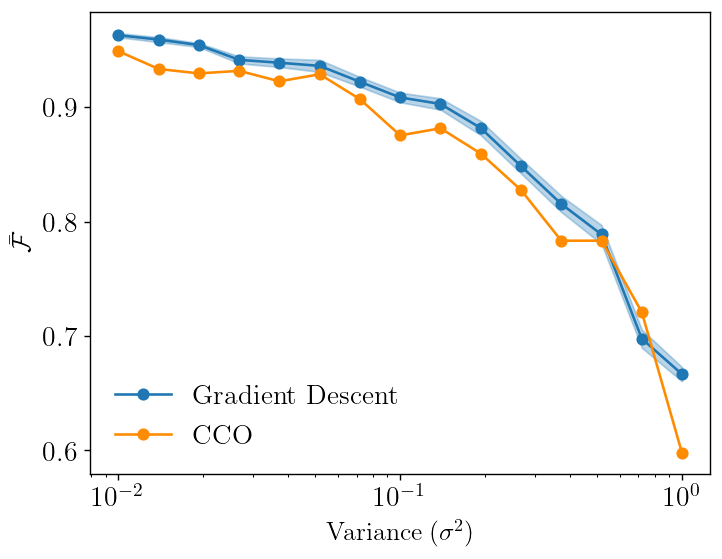

In [6]:
arr = np.array(avg_fids_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(errs, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(errs, lower, upper, color='C0', alpha=0.3)

plt.plot(errs, avg_fids_mosek, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Variance} $(\sigma^2)$", fontsize=15.0)
plt.ylabel(r"$\bar{\mathcal{F}}$", fontsize=15.0)

plt.xscale("log")

plt.legend(fancybox=True, ncol=1, frameon=False);

if eta < 1.0:
    plt.savefig("figs/lossy/lossy_noise_fidelity.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_noise_fidelity.png", dpi=300, bbox_inches='tight')

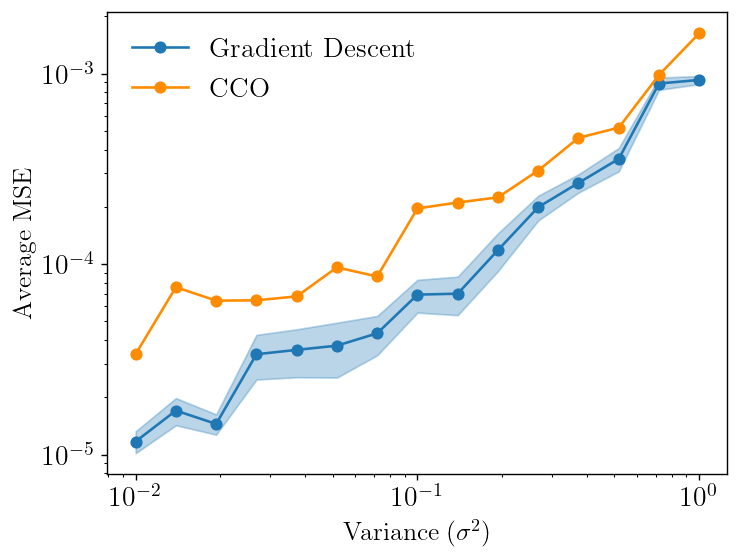

In [7]:
arr = np.array(avg_mses_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(errs, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(errs, lower, upper, color='C0', alpha=0.3)

plt.plot(errs, avg_mses_mosek, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Variance} $(\sigma^2)$", fontsize=15.0)
plt.ylabel(r"$\textrm{Average MSE}$", fontsize=15.0)

plt.xscale("log")
plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False);

if eta < 1.0:
    plt.savefig("figs/lossy/lossy_noise_mse.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_noise_mse.png", dpi=300, bbox_inches='tight')

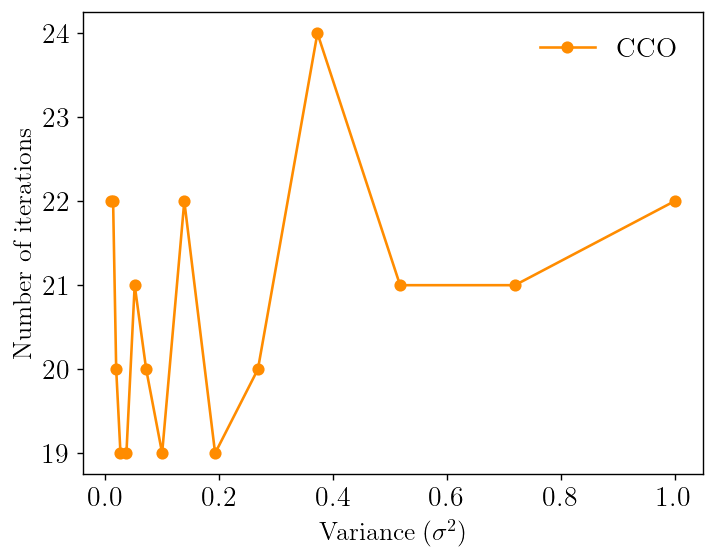

In [8]:
plt.plot(errs, iters_mosek, label=r'\textrm{CCO}', marker="o", color="darkorange")
plt.xlabel(r"\textrm{Variance} $(\sigma^2)$", fontsize=15.0)
plt.ylabel(r"$\textrm{Number of iterations}$", fontsize=15.0)
plt.legend(fancybox=True, ncol=1, frameon=False);

if eta < 1.0:
    plt.savefig("figs/lossy/lossy_noise_iters.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_noise_iters.png", dpi=300, bbox_inches='tight')